# Cell population simulation: wild type has growth advantage over mutant

Summary of code:
1) Define cell object to record 

    - self index
    - index of parent
    - birth time
    - plasmid count at birth
    - steady state plasmid count
    - division time (dependent on existence of plasmids) <p>&nbsp;</p>
    
2) Simulate population starting with 1 cell at time 0 with a nonzero number of plasmids

    - Calculate steady state plasmid number. **Assume that plasmid distribution reaches steady state before division**. 
        + If initial plasmid count is 0, steady state plasmid count is 0
        + If initial plasmid count > 0, steady state plasmid count is sampled from the distribution Binom([max plasmid number n], 0.5)
            *Question: This means that a cell can lose plasmids entirely - should I choose a different distribution? <p>&nbsp;</p>
        
    - Partition plasmids to two daughter cells.
        + Number of plasmids in daughter 1: sample from Binom([steady state plasmid number], 0.5)
        + Number of plasmids in daughter 2: [steady state plasmid number]-[daughter 1 plasmid number] <p>&nbsp;</p>
    
    - Create two new daughter cells.
        + Birth times are the current cell's division time
        + Division time is [birth time] + a_m if they have 0 plasmids, and [birth time] + a_w if they have more than 0 plasmids <p>&nbsp;</p>

    - Remove current cell from queue of cells to process; add daughter cells. Sort the queue by division time so that the next cell to divide is processed in the next loop <p>&nbsp;</p>

3) I store all cells that have already divided in a list called "cells", and I store all cells in the queue, aka the currently alive population, in a list called "Q". 
    



In [1]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt

In [2]:
class cell:
    def __init__(self,index,parent,birth,init_plasmid,tau):
        '''Initializes cell attributes
        param:: index: cell index
        param:: parent: index of parent cell
        param:: birth: birth time
        param:: init_plasmid: plasmids partitioned to cell at birth
        param:: tau: growth rate
        return:: None
        '''
        self.index=index
        self.parent = parent
        self.birth = birth
        self.init_plasmid = init_plasmid
        self.ss_plasmid = 100 #placeholder number; will calculate steady state plasmid number later
        self.div = birth+tau

In [3]:
def simulation(Nmax, a_w, a_m, n, p):
    
    init_plasmid=1 #initial plasmid number of first cell. Arbitrary- just can't be 0
    c= cell(0,[],0,init_plasmid,a_w)   #index,parent,birth,initialplasmid,tau
    Q=[c] #queue of cells that have not divided yet (currently alive cells)
    cells=[] #list of cells that have divided already
    N=0 #index of initial cell c

    while len(cells)<Nmax:
        current=Q[0]

        #Calculate steady state plasmid number
        if current.init_plasmid==0:
            ss_plasmid_num=0
        else:
            ss_plasmid_num=np.random.binomial(n,p,size=None)
        current.ss_plasmid=ss_plasmid_num

        #Partition plasmids between two daughter cells
        d1_plasmids=np.random.binomial(ss_plasmid_num,p,size=None)
        d2_plasmids=ss_plasmid_num-d1_plasmids

        #Create two new daughter cells
        if d1_plasmids==0:
            daughter1=cell(N+1, current.index, current.div, d1_plasmids, a_m) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter1=cell(N+1, current.index, current.div, d1_plasmids, a_w) #index,parentindex,birth,initialplasmids,tau
        if d2_plasmids==0:
            daughter2=cell(N+2, current.index, current.div, d2_plasmids, a_m) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter2=cell(N+2, current.index, current.div, d2_plasmids, a_w) #index,parentindex,birth,initialplasmids,tau
    
        #Add current cell to vector 'cells'
        cells.extend([current])
    
        #Update index for next time
        N+=2

        #Update Q for next time - remove current cell, add daughter cells, sort by age so Q[0] is youngest
        Q.remove(current)
        Q.extend([daughter1,daughter2])
        Q=sorted(Q,key=lambda x: x.div, reverse=False)
    return Q, cells

In [4]:
Nmax=20000 #number of cells processed by simulation
a_w=1 #wild type mean lifetime (note: the population with the shorter lifetime has the advantage)
a_m=2 #0 plasmid mean lifetime
n=20 #max number of plasmids
p=.5 #probability of success in binomial distribution; used to calculate steady state plasmid num and also 
     #daughter plasmid partitioning


In [5]:
Q, cells = simulation(Nmax, a_w, a_m, n, p)

## Result:

Histogram: horizontal axis is plasmid number, bar heights are number of cells with that number of plasmids. 

In the two code cells below, I create histograms of the already divided cell population (aka the cells in "cells" list) for 1) the plasmid numbers at birth and 2) the plasmid numbers at division.

##### Experiment 1:
- Max plasmids = 20
- Cells processed = 20,000
- a_w = a_m = 1

Trial 1: 600 cells lost plasmid

Trial 2: 646 cells lost plasmid

Trial 3: 423 cells lost plasmid

##### Experiment 2: 
- Max plasmids = 20
- Cells processed = 30,000
- a_w = a_m = 1

Trial 1: 985 cells lost plasmid

Trial 2: 454 cells lost plasmid

Trial 3: 1744 cells lost plasmid 

There is a large variation in plasmid loss- maybe because the trials are going for different time periods. The goal of increasing the number of cells processed was to see how quickly the system approaches the absorbing state of 0 plasmids. I could keep track of elapsed time and run the loop for a specified amount of time instead.

##### Experiment 3: 
- Max plasmids = 20
- Cells processed = 20,000
- a_w = 1, a_m = 10 (so lifetime of cells with 0 plasmids is 10 times longer than lifetime of cells with plasmids)

Trial 1: 0 cells lost plasmid 

Trial 2: 0 cells

##### Experiment 4: 
- Max plasmids = 20
- Cells processed = 20,000
- a_w = 1, a_m = 2

Trial 1: 74 cells lost plasmid 

Trial 2: 176 cells

Trial 3: 160 cells

Experiments 3 and 4 can be compared to experiment 1. As expected, a wild type advantage decreases population plasmid loss (though I am not sure at what rate).

Do the first few generations strongly influence the outcome of the simulation?

(array([  86.,    0.,    4.,   23.,   93.,  288.,  725., 1464., 2317.,
        3196., 3492., 3132., 2443., 1567.,  760.,  274.,  105.,   26.,
           5.,    0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <BarContainer object of 20 artists>)

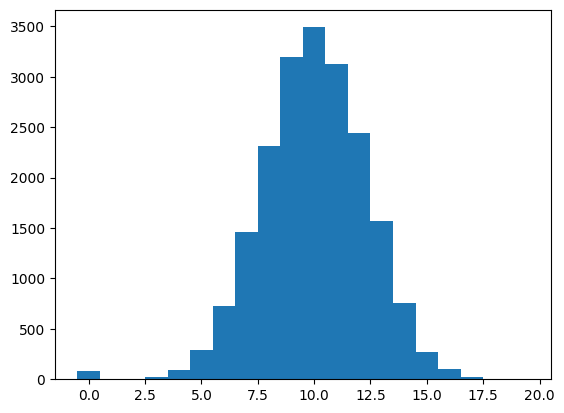

In [6]:
cellplasmids=[]
for i in cells:
    cellplasmids.extend([i.ss_plasmid])
plt.hist(cellplasmids,bins=n, range=[-.5,19.5])

(array([8.600e+01, 4.640e+02, 1.325e+03, 2.604e+03, 3.760e+03, 4.039e+03,
        3.294e+03, 2.280e+03, 1.240e+03, 6.160e+02, 2.120e+02, 5.900e+01,
        1.800e+01, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <BarContainer object of 20 artists>)

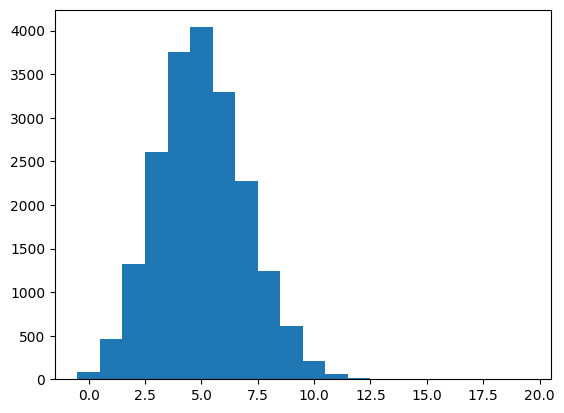

In [7]:
cellplasmids_init=[]
for i in cells:
    cellplasmids_init.extend([i.init_plasmid])
plt.hist(cellplasmids_init,bins=n, range=[-.5,19.5])

The following cell creates the same histogram, but instead it uses the cells from the currently alive population stored in "Q" instead of the cells that have already divided in "cells". 

(array([2.190e+02, 4.330e+02, 1.353e+03, 2.697e+03, 3.700e+03, 3.921e+03,
        3.299e+03, 2.271e+03, 1.275e+03, 5.240e+02, 2.240e+02, 6.900e+01,
        1.300e+01, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <BarContainer object of 20 artists>)

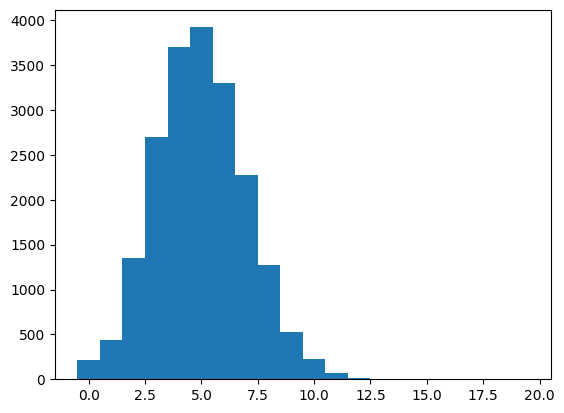

In [8]:
Q_init=[]
for i in Q:
    Q_init.extend([i.init_plasmid])
plt.hist(Q_init,bins=n, range=[-.5,19.5])